In [61]:
import pandas as pd
import numpy as np

In [62]:
raw_data = pd.read_csv("Bitcoin History.csv")
raw_data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Feb 09, 2024","47,545.4","45,293.3","47,710.2","45,254.2",86.85K,4.97%
1,"Feb 08, 2024","45,293.3","44,346.2","45,579.2","44,336.4",66.38K,2.15%
2,"Feb 07, 2024","44,339.8","43,088.4","44,367.9","42,783.5",48.57K,2.91%
3,"Feb 06, 2024","43,087.7","42,697.6","43,375.5","42,566.8",33.32K,0.91%
4,"Feb 05, 2024","42,697.2","42,581.4","43,532.2","42,272.5",39.26K,0.27%


In [63]:
raw_data["Date"][180].replace(",","").split(" ")

['Aug', '13', '2023']

In [64]:
pd.to_datetime("2023-8-13")

Timestamp('2023-08-13 00:00:00')

In [65]:
def parse_date(date:str) ->pd.Timestamp:
    months = {"Jan":1,
              "Feb":2,
              "Mar":3,
              "Apr":4,
              "May":5,
              "Jun":6,
              "Jul":7,
              "Aug":8,
              "Sep":9,
              "Oct":10,
              "Nov":11,
              "Dec":12}
    
    list_date = date.replace(",","").split(" ")

    year = list_date[2]
    day = list_date[1]
    month = months[list_date[0]]

    datetime_date = pd.to_datetime(f"{year}-{month}-{day}")
    
    return datetime_date


In [66]:
raw_data["Date"] = raw_data["Date"].map(parse_date)
raw_data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2024-02-09,"47,545.4","45,293.3","47,710.2","45,254.2",86.85K,4.97%
1,2024-02-08,"45,293.3","44,346.2","45,579.2","44,336.4",66.38K,2.15%
2,2024-02-07,"44,339.8","43,088.4","44,367.9","42,783.5",48.57K,2.91%
3,2024-02-06,"43,087.7","42,697.6","43,375.5","42,566.8",33.32K,0.91%
4,2024-02-05,"42,697.2","42,581.4","43,532.2","42,272.5",39.26K,0.27%


In [67]:
def split_dates(data:pd.DataFrame) -> pd.DataFrame:
    copy = data.copy()

    copy["day"] = copy["Date"].dt.day
    copy["month"] = copy["Date"].dt.month
    copy["year"] = copy["Date"].dt.year
    copy["day_of_week"] = copy["Date"].dt.day_of_week

    copy = copy.drop("Date", axis=1)

    return copy

df = split_dates(raw_data)
df.head()

,Price,Open,High,Low,Vol.,Change %,day,month,year,day_of_week
0,"47,545.4","45,293.3","47,710.2","45,254.2",86.85K,4.97%,9,2,2024,4
1,"45,293.3","44,346.2","45,579.2","44,336.4",66.38K,2.15%,8,2,2024,3
2,"44,339.8","43,088.4","44,367.9","42,783.5",48.57K,2.91%,7,2,2024,2
3,"43,087.7","42,697.6","43,375.5","42,566.8",33.32K,0.91%,6,2,2024,1
4,"42,697.2","42,581.4","43,532.2","42,272.5",39.26K,0.27%,5,2,2024,0


In [68]:
df_main = df.drop(["Open","High","Low","Change %"], axis=1)
df_main.head()

,Price,Vol.,day,month,year,day_of_week
0,"47,545.4",86.85K,9,2,2024,4
1,"45,293.3",66.38K,8,2,2024,3
2,"44,339.8",48.57K,7,2,2024,2
3,"43,087.7",33.32K,6,2,2024,1
4,"42,697.2",39.26K,5,2,2024,0


In [69]:
def parse_price(value):
    return float(value.replace(",",""))

def parse_volume(volume):
    if volume == "-":
        return 0
    return float(volume[:4])

df_main["Price"] = df_main["Price"].map(parse_price)
df_main["Vol."] = df_main["Vol."].map(parse_volume)

In [70]:
df_main = pd.get_dummies(df_main,columns=["day_of_week"], drop_first=True)

In [71]:
today = pd.to_datetime("2024-02-09")

covid_start = pd.to_datetime("2020-01-15")
ukr_war = pd.to_datetime("2022-02-24")

print(today - covid_start)
print(today - ukr_war)

1486 days 00:00:00
715 days 00:00:00


In [72]:
print(df.shape[0])

is_covid_array = [True for _ in range(1486)] + [False for _ in range(df.shape[0]-1486)]
is_war = [True for _ in range(715)] + [False for _ in range(df.shape[0]-715)]

print(f"{len(is_covid_array)}    {len(is_war)}")

4955
4955    4955


In [73]:
df_main["is_covid"] = is_covid_array
df_main["is_war"] = is_war

<AxesSubplot: xlabel='month', ylabel='Price'>

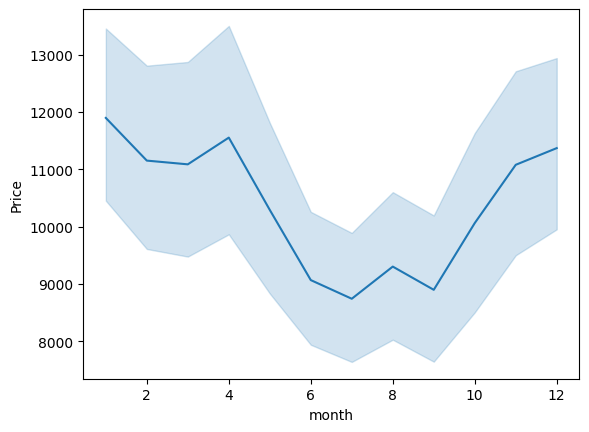

In [74]:
import seaborn as sns

sns.lineplot(df_main,x="month",y="Price")

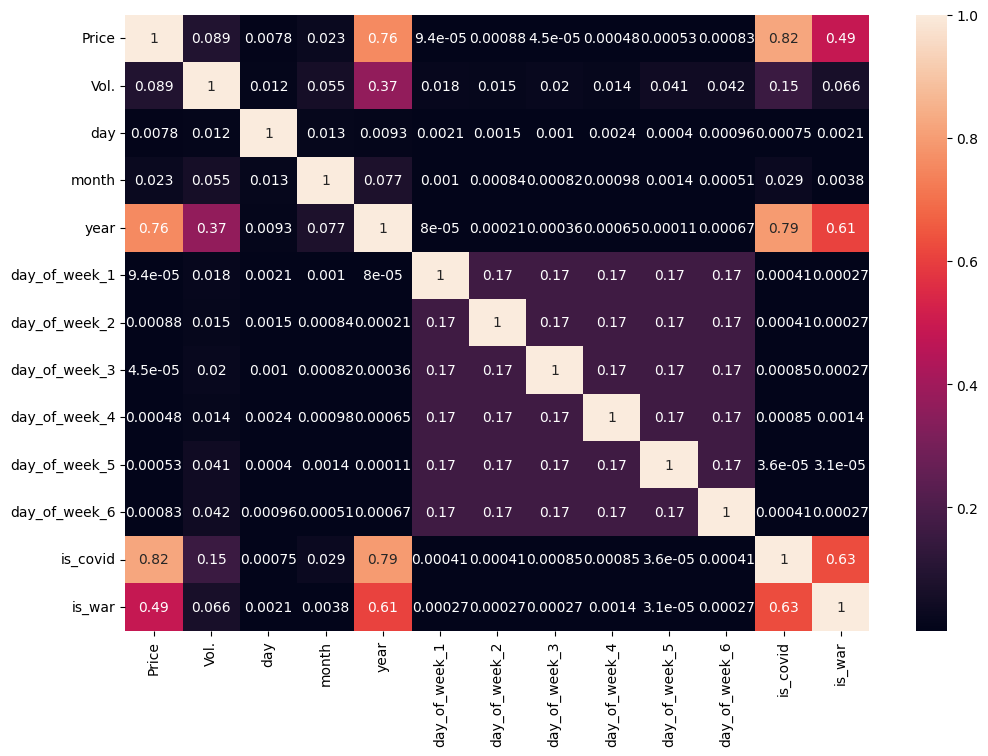

In [75]:
import matplotlib.pyplot as plt

plt.figure().set_size_inches(12,8)
sns.heatmap(abs(df_main.corr()), annot=True)
plt.show()

In [76]:
train = df_main[df_main["year"]<2023]
test = df_main[df_main["year"]>=2023]

In [77]:

def train_test_split(y_true:str,train:pd.DataFrame,test:pd.DataFrame, log:bool, cols_to_drop:list = None) -> tuple:
    
    if cols_to_drop != None:
        X_train = train.drop([y_true] + cols_to_drop, axis=1)
        X_test = test.drop([y_true] + cols_to_drop, axis=1)  
    
    else:
        X_train = train.drop(y_true, axis=1)
        X_test = test.drop(y_true, axis=1)    

    if log == False:
        y_train = train[y_true]
        y_test = test[y_true]
    
    elif log == True:
        y_train = np.log(train[y_true])
        y_test = np.log(test[y_true])

    return X_train,X_test,y_train,y_test

cols_to_drop = ["Price"]

X_train,X_test,y_train,y_test = train_test_split("Vol.",
                                                 train,
                                                 test,
                                                 log=False,
                                                 cols_to_drop=cols_to_drop)

In [78]:
X_train

,day,month,year,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,is_covid,is_war
405,31,12,2022,0,0,0,0,1,0,True,True
406,30,12,2022,0,0,0,1,0,0,True,True
407,29,12,2022,0,0,1,0,0,0,True,True
408,28,12,2022,0,1,0,0,0,0,True,True
409,27,12,2022,1,0,0,0,0,0,True,True
...,...,...,...,...,...,...,...,...,...,...,...
4950,22,7,2010,0,0,1,0,0,0,False,False
4951,21,7,2010,0,1,0,0,0,0,False,False
4952,20,7,2010,1,0,0,0,0,0,False,False
4953,19,7,2010,0,0,0,0,0,0,False,False


In [79]:
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Normalizer

lasso_pipe = Pipeline([("scaler",StandardScaler()),( "lasso",Lasso(max_iter=500,alpha=1))])

lasso_pipe.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso', Lasso(alpha=1, max_iter=500))])

In [80]:
lasso_pipe["lasso"].coef_

array([  2.66657112,   0.24529237, 128.02989249,   0.        ,
        -0.        ,   0.18051683,  -0.        ,  -7.65688065,
        -7.71094652, -53.45288379,  -0.        ])

In [81]:
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse

def print_deviations(estimator,X_test,y_test,log_target:bool):
    if log_target == False:
        print(f"MAE: {mae(y_test,estimator.predict(X_test))}")
        print(f"MSE: {mse(y_test,estimator.predict(X_test))}")
        print(f"RMSE: {mse(y_test,estimator.predict(X_test))**0.5}")
        
        return {"MAE":mae(y_test,estimator.predict(X_test)),
            "MSE":mse(y_test,estimator.predict(X_test)),
            "RMSE":mse(y_test,estimator.predict(X_test))**0.5}
    
    elif log_target == True:
        print(f"RMLSE: {mse(y_test,estimator.predict(X_test))**0.5}")
        
        return {"RMSLE":mse(y_test,estimator.predict(X_test))**0.5}



def plot_results(estimator,X_train,X_test,y_train,y_test,title:str = None):
    """Графическое отображение предсказаний модели"""
    
    train_preds = estimator.predict(X_train)
    test_preds = estimator.predict(X_test)

    df_train = pd.DataFrame({"X_train_preds":train_preds,
                             "y_train":y_train})
    
    df_test = pd.DataFrame({"X_test_preds":test_preds,
                            "y_test":y_test})
    
    plt.figure().set_size_inches(12,8)

    ax1 = plt.subplot(1,2,1)
    plt.title(f"Train {title}")
    sns.lineplot(df_train)
    plt.tight_layout()
    # plt.show()

    ax2 = plt.subplot(1,2,2)
    plt.title(f"Test {title}")
    sns.lineplot(df_test)
    plt.tight_layout()
    # plt.show()

print_deviations(lasso_pipe,X_test,y_test,log_target=False)

MAE: 209.08189881504984
MSE: 48915.258186568295
RMSE: 221.16794113652253


{'MAE': 209.08189881504984,
 'MSE': 48915.258186568295,
 'RMSE': 221.16794113652253}

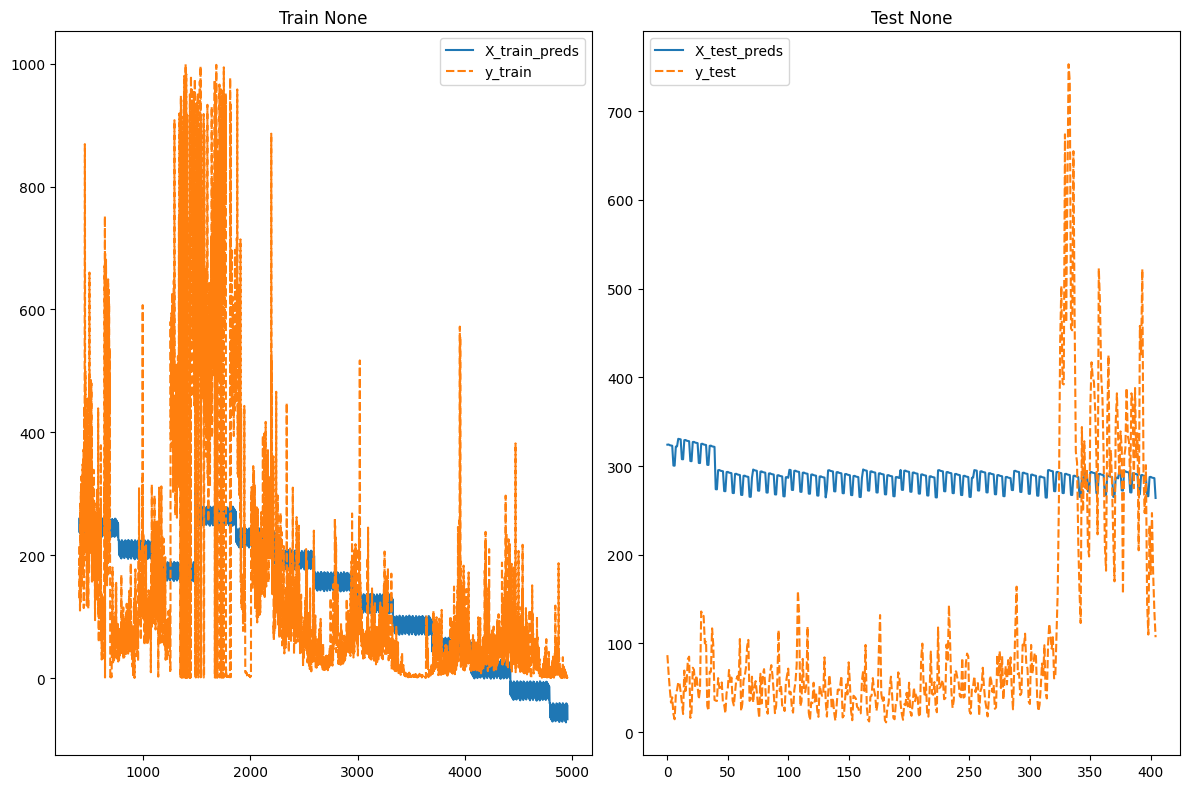

In [82]:
plot_results(lasso_pipe,X_train,X_test,y_train,y_test)

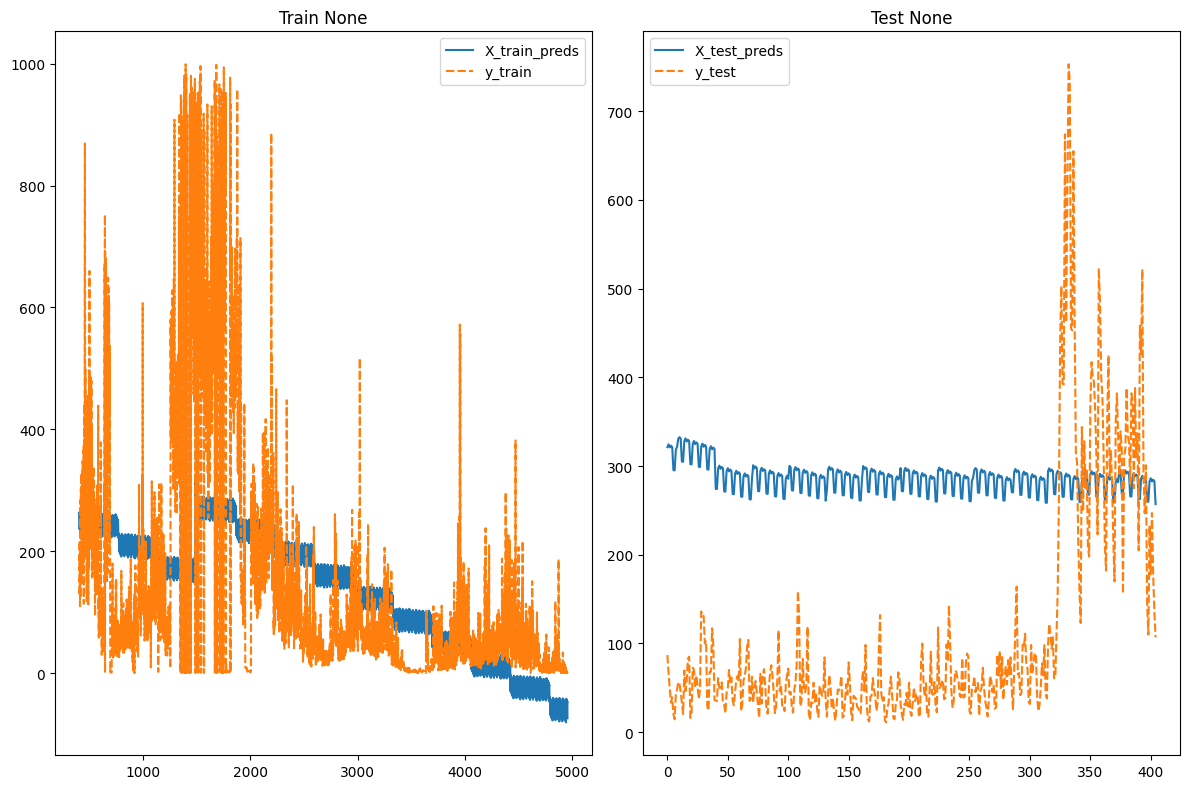

In [83]:
from sklearn.linear_model import LinearRegression,LogisticRegression

linear_pipe = Pipeline([("scaler", StandardScaler()),("linear",LinearRegression())])
# logistic_pipe = Pipeline([("scaler", StandardScaler()),("logistic",LogisticRegression())])

linear_pipe.fit(X_train,y_train)
# logistic_pipe.fit(X_train,y_train)

plot_results(linear_pipe,X_train,X_test,y_train,y_test)

# plot_results(logistic_pipe,X_train,X_test,y_train,y_test)

In [84]:
params = {"learning_rate":[0.2,.3,.4,.5,.6,.7,.8,.9,.95,1.],
          "n_estimators":[_ for _ in range(40,100,5)],
          "max_depth":[_ for _ in range(1,5)]}

In [85]:
from xgboost import XGBRegressor

def xgb_Gridsearch(X_train,X_test,y_train,y_test, is_log:bool = False):
    
    results = {}

    learning_rate = [0.2,.3,.4,.5,.6,.7,.8,.9,.95,1.]
    n_estim = [_ for _ in range(40,100,5)]
    max_depth = [_ for _ in range(1,5)]

    for lr in learning_rate:
        for estim in n_estim:
            for depth in max_depth:
                pipe = Pipeline([("scaler",StandardScaler()),("xgb",XGBRegressor(n_estimators = estim, max_depth=depth, learning_rate=lr))])

                pipe.fit(X_train,y_train)

                results[f"{estim}_{depth}_{lr}"] = [print_deviations(pipe,X_test,y_test,is_log), pipe]
    
    return results


In [86]:


# xgb_pipe = Pipeline([("scaler",StandardScaler()),("xgb",XGBRegressor(n_estimators = 50, max_depth=2, learning_rate=0.4))])

# xgb_pipe.fit(X_train,y_train)

# print_deviations(xgb_pipe,X_test,y_test,log_target=False)

xgb_dict = xgb_Gridsearch(X_train,X_test,y_train,y_test)
# plot_results(xgb_pipe,X_train,X_test,y_train,y_test)


MAE: 142.83074911988814
MSE: 23982.93748090254
RMSE: 154.86425501355222
MAE: 174.0149237211251
MSE: 34540.17081633099
RMSE: 185.8498609532194
MAE: 179.4870346295392
MSE: 37810.42321076599
RMSE: 194.44902471024633
MAE: 190.72365684603466
MSE: 44684.63184096375
RMSE: 211.3873975452741
MAE: 147.5998253565659
MSE: 25244.081985793717
RMSE: 158.88386320137647
MAE: 176.30870077250918
MSE: 35508.693580331535
RMSE: 188.43750576870713
MAE: 181.15984476725262
MSE: 38790.76184716867
RMSE: 196.9537048322998
MAE: 190.76650053047837
MSE: 44932.995297925416
RMSE: 211.9740439250179
MAE: 152.28327823591823
MSE: 26574.834775397576
RMSE: 163.01789710150715
MAE: 176.1258519904996
MSE: 35697.20374402014
RMSE: 188.93703645400004
MAE: 184.6329273026078
MSE: 40629.576822499934
RMSE: 201.56779708698494
MAE: 191.3277148833098
MSE: 45392.8023613112
RMSE: 213.05586676107092
MAE: 151.83650364251787
MSE: 26444.17407872597
RMSE: 162.61664760634432
MAE: 175.0366561550564
MSE: 35278.0093070949
RMSE: 187.82441083920614


In [87]:
def serch_min_mae(results:dict):
    d_mae = {}

    for k in xgb_dict.keys():
        mae = xgb_dict.get(k)[0]["MAE"]
        d_mae[f"{k}"] = mae

    min_mae = min(d_mae.values())

    for k in xgb_dict.keys():
        if xgb_dict.get(k)[0]["MAE"] == min_mae:
            # print(k)
            return k

def search_min_mse(results:dict):
    d_mse = {}

    for k in results.keys():
        mse = results.get(k)[0]["MSE"]

        d_mse[f"{k}"] = mse

    min_mse = min(d_mse.values())

    for k in results.keys():
        if results.get(k)[0]["MSE"] == min_mse:
            # print(k)
            return k

def search_min_rmse(results:dict):
    d_rmse = {}

    for k in results.keys():
        rmse = results.get(k)[0]["RMSE"]

        d_rmse[f"{k}"] = rmse

    min_rmse = min(d_rmse.values())

    for k in results.keys():
        if results.get(k)[0]["RMSE"] == min_rmse:
            # print(k)
            return k

In [88]:
serch_min_mae(xgb_dict), search_min_mse(xgb_dict), search_min_rmse(xgb_dict)

('40_1_0.2', '40_1_0.2', '40_1_0.2')

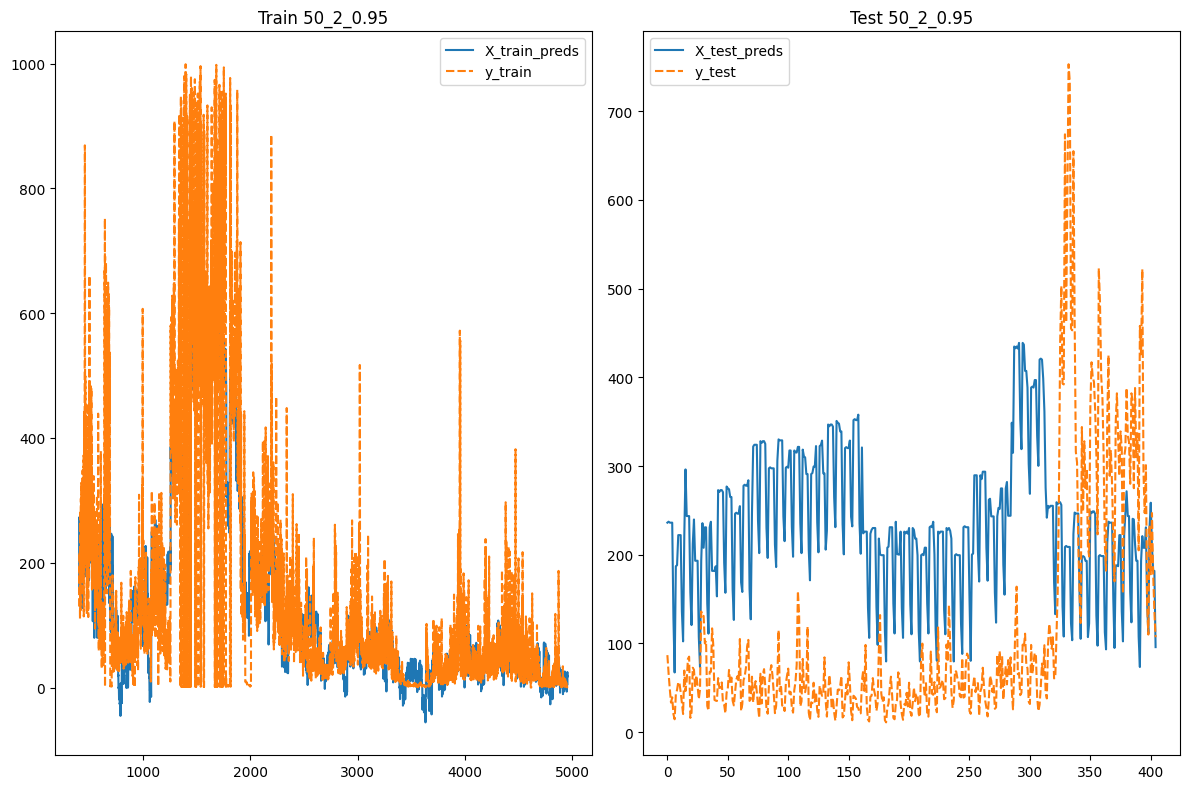

In [90]:
key = "50_2_0.95"
plot_results(xgb_dict[key][1],X_train,X_test,y_train,y_test,key)

In [50]:
import pickle as pkl

pkl_filename = "xgb_volume.pkl" 
with open(pkl_filename, 'wb') as file: 
    pkl.dump(xgb_dict[key][1], file)

In [113]:
X = df_main.drop(["Price","Vol."],axis=1)

model = xgb_dict[key][1]

predictions = model.predict(X)

In [114]:
df_main["Vol."] = predictions

In [115]:
train = df_main[df_main["year"]<2023]
test = df_main[df_main["year"]>=2023]

In [116]:
X_train,X_test,y_train,y_test = train_test_split("Price",train,test,log=True,cols_to_drop=None)

In [117]:
X_train

,Vol.,day,month,year,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,is_covid,is_war
405,153.067047,31,12,2022,0,0,0,0,1,0,True,True
406,272.867218,30,12,2022,0,0,0,1,0,0,True,True
407,270.877594,29,12,2022,0,0,1,0,0,0,True,True
408,272.867218,28,12,2022,0,1,0,0,0,0,True,True
409,272.867218,27,12,2022,1,0,0,0,0,0,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...
4950,17.498306,22,7,2010,0,0,1,0,0,0,False,False
4951,19.487932,21,7,2010,0,1,0,0,0,0,False,False
4952,16.404221,20,7,2010,1,0,0,0,0,0,False,False
4953,24.852997,19,7,2010,0,0,0,0,0,0,False,False


RMLSE: 0.4463663482716913


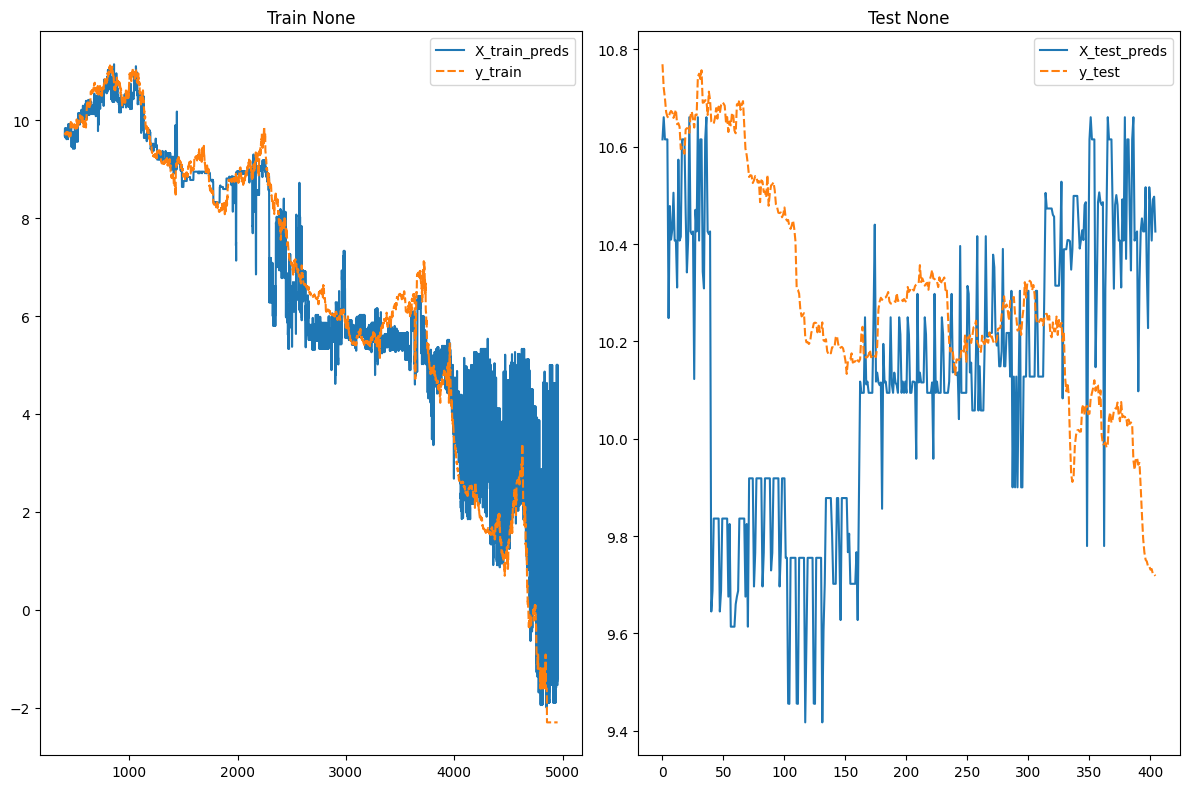

In [126]:
main_xgb_pipe = Pipeline([("scaler", Normalizer()),("xgb",XGBRegressor(n_estimators = 30,max_depth = 5,learning_rate = 0.19))])

main_xgb_pipe.fit(X_train,y_train)

print_deviations(main_xgb_pipe, X_test,y_test,log_target=True)

plot_results(main_xgb_pipe,X_train,X_test,y_train,y_test)